In [51]:
import pandas as pd
import numpy as np


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Read data and drop irrelevant columns

In [52]:
df_wioa = pd.read_csv("WIOA_cleaned 2.csv")

df_wioa = df_wioa.dropna(subset=["108A_workforce_board_code"])
df_wioa = df_wioa.drop(columns=["108A_workforce_board_code", "301_veteran_status", "316_spouse_of_veteran", "400_employment_status_before_training", "402_unemployed_more_than_7_weeks", "403_occupation_before_training",\
    "413_migrant_status", "802_federal_or_state_assistance", "800_homelessness", "801_ex_offender","806_single_parent", "1700_3Q_wage_prior", "1701_2Q_wage_prior", "1704_2Q_wage_after", "1705_3Q_wage_after", "1706_4Q_wage_after"])

df_wioa.isna().sum()

/var/folders/st/0v15z_sd1nd54v4j8g1xlhvr0000gn/T/ipykernel_175/2061142547.py:1: DtypeWarning: Columns (56) have mixed types. Specify dtype option on import or set low_memory=False.
  df_wioa = pd.read_csv("WIOA_cleaned 2.csv")


100_id                                       0
201_sex                                      0
202_disability                               0
203_disability_type                          0
210_hispanic                                 0
211_indian                                   0
212_asian                                    0
213_black                                    0
214_PI                                       0
215_white                                    0
407_high_school_grades_completed             0
408_degree_obtained                          0
900_date_of_program_entry                    0
901_date_of_program_exit                 34888
903_adult                                    0
904_dislocated_worker                     7167
905_youth                                    0
907_incumbent_worker_training             7167
908_rapid_response                       16665
910_adult_education                          0
911_job_corp                            243077
914_veteran  

## Format dates into datetime dtype

In [53]:
# Clean and convert float-formatted dates to datetime
df_wioa["900_date_of_program_entry"] = pd.to_datetime(
    df_wioa["900_date_of_program_entry"].dropna().astype(int).astype(str),
    format="%Y%m%d",
    errors="coerce"
)

df_wioa["901_date_of_program_exit"] = pd.to_datetime(
    df_wioa["901_date_of_program_exit"].dropna().astype(int).astype(str),
    format="%Y%m%d",
    errors="coerce"
)

df_wioa["annual_income_before"] = df_wioa["1702_1Q_wage_prior"] * 4
df_wioa["annual_income_after"] = df_wioa["1703_1Q_wage_after"] * 4

df_wioa = df_wioa.dropna(subset=["1702_1Q_wage_prior", "1703_1Q_wage_after", "901_date_of_program_exit"])

In [54]:
# List of WIOA-related columns
wioa_cols = [
    "911_job_corp", "916_vocational", "917_vocational_rehabilitation",
    "918_wagner_peyser_employment_service", "921_training_with_SNAP", "922_other",
    "930_pay_per_performance", "931_apprenticeship", "932_dislocated_worker_grant",
    "1205_work_experience", "1303_training_1", "1307_training_1_completed"
]

# Step 1: Fill missing values with 0
df_wioa[wioa_cols] = df_wioa[wioa_cols].fillna(0)

# Step 2: Create 'WIOA_participant_status' — 1 if any column > 0 in the row, else 0
df_wioa["WIOA_participant_status"] = (df_wioa[wioa_cols].gt(0).any(axis=1)).astype(int)

df_wioa.drop(columns=wioa_cols, inplace=True)

In [55]:
df_wioa.isna().sum()

100_id                                 0
201_sex                                0
202_disability                         0
203_disability_type                    0
210_hispanic                           0
211_indian                             0
212_asian                              0
213_black                              0
214_PI                                 0
215_white                              0
407_high_school_grades_completed       0
408_degree_obtained                    0
900_date_of_program_entry              0
901_date_of_program_exit               0
903_adult                              0
904_dislocated_worker                  0
905_youth                              0
907_incumbent_worker_training          0
908_rapid_response                  4903
910_adult_education                    0
914_veteran                          821
1600_1Q_employed                       0
1602_2Q_employed                       0
1604_3Q_employed                       0
1606_4Q_employed

## Stratified Sampling

In [ ]:
import pandas as pd
import numpy as np
import math

# Define the 6-month timedelta
six_months = pd.Timedelta(days=183)
area_number = "LWDA 1"
start_year = 2020

# Filter conditions
df_for_sampling = df_wioa[
    (df_wioa["area_number"] == area_number) &
    (df_wioa["900_date_of_program_entry"].dt.year == start_year) &
    (df_wioa["901_date_of_program_exit"] - df_wioa["900_date_of_program_entry"] > six_months)
]

# Map race columns to a single 'race' column
race_columns = {
    '211_indian': 'indian',
    '212_asian': 'asian',
    '213_black': 'black',
    '214_PI': 'hawaiian_pacific_islander',
    '215_white': 'white'
}

def extract_race(row):
    for col, race in race_columns.items():
        if row[col] == 1:
            return race
    return 'unknown'

df_for_sampling['race'] = df_for_sampling.apply(extract_race, axis=1)

# Gender
df_for_sampling['gender'] = df_for_sampling['201_sex'].map({1: 'male', 2: 'female'})

# Ethnicity
df_for_sampling['ethnicity'] = df_for_sampling['210_hispanic'].map({1: 'hispanic', 0: 'nonhispanic'})

# Disability
df_for_sampling['disability'] = df_for_sampling['202_disability'].map({1: 'disability_yes', 0: 'disability_no'})

# Veteran
df_for_sampling['veteran'] = df_for_sampling['914_veteran'].map({1: 'veteran', 0: 'nonveteran'})

# Education (you can tweak logic based on degree/grade columns)
def classify_education(row):
    degree_code = row['408_degree_obtained']
    
    if degree_code in [0]:
        return 'less_hs'
    elif degree_code in [1,2,3]:
        return 'hs'
    elif degree_code in [4,5,6,7,8]:
        return 'college'
    else:
        return 'unknown'  # fallback in case of unexpected codes

df_for_sampling['education'] = df_for_sampling.apply(classify_education, axis=1)

# Load proportions file
lwda_props = pd.read_csv('final_lwda_props_compiled.csv')

target_row = lwda_props[
    (lwda_props['LWDA Area'] == area_number) & 
    (lwda_props['year'] == start_year)
].iloc[0]

# Build population proportions dictionary
pop_props = {
    'race': {
        'white': target_row['race_white_prop'],
        'black': target_row['race_black_prop'],
        'asian': target_row['race_asian_prop'],
        'hawaiian_pacific_islander': target_row['race_PI_prop'],
        'indian': target_row['race_indian_prop']
    },
    'gender': {
        'female': target_row['female_prop'],
        'male': target_row['male_prop']
    },
    'ethnicity': {
        'hispanic': target_row['hispanic_prop'],
        'nonhispanic': target_row['nonhispanic_prop']
    },
    'education': {
        'hs': target_row['hs_prop'],
        'less_hs': target_row['less_hs_prop'],
        'college': target_row['college_prop']
    },
    'veteran': {
        'veteran': target_row['veteran_prop'],
        'nonveteran': 1 - target_row['veteran_prop']  # assuming binary
    },
    'disability': {
        'disability_yes': target_row['disability_yes_prop'],
        'disability_no': target_row['disability_no_prop']
    }
}

# Cochran sample size calculation
def calculate_sample_size(p, N, z=1.96, e=0.05):
    n0 = (z**2 * p * (1 - p)) / (e**2)
    n = n0 / (1 + ((n0 - 1) / N))
    return math.ceil(n)

# Sample size
population_size = df_for_sampling.drop_duplicates().shape[0]
sample_size = calculate_sample_size(p=0.5, N=population_size, z=1.96, e=0.05)

# Stratified sampling function
def sample_to_match_pop(df, pop_props, sample_size, random_state=None):
    weights = np.ones(len(df))

    for covariate, target_props in pop_props.items():
        observed = df[covariate].value_counts(normalize=True).to_dict()

        def weight_factor(value):
            if value in target_props and value in observed and observed[value] > 0:
                return target_props[value] / observed[value]
            else:
                # Assign a neutral weight or a small constant if observed is zero
                return 1.0

        weights *= df[covariate].apply(weight_factor).values

    weights /= weights.sum()
    sampled_df = df.sample(n=sample_size, weights=weights, random_state=random_state)
    return sampled_df

# Sample
sampled_df = sample_to_match_pop(df_for_sampling, pop_props, sample_size=sample_size, random_state=42)

# Display comparisons
print("Sampled race distribution:")
print(sampled_df['race'].value_counts(normalize=True))
print("\nTarget race distribution:")
print(pd.Series(pop_props['race']))

print("\nSampled gender distribution:")
print(sampled_df['gender'].value_counts(normalize=True))
print("\nTarget gender distribution:")
print(pd.Series(pop_props['gender']))

print("\nSampled ethnicity distribution:")
print(sampled_df['ethnicity'].value_counts(normalize=True))
print("\nTarget ethnicity distribution:")
print(pd.Series(pop_props['ethnicity']))

Sampled race distribution:
race
white      0.791667
black      0.158333
unknown    0.033333
asian      0.016667
Name: proportion, dtype: float64

Target race distribution:
white                        0.893169
black                        0.091828
asian                        0.010236
hawaiian_pacific_islander    0.000372
indian                       0.004395
dtype: float64

Sampled gender distribution:
gender
female    0.691667
male      0.308333
Name: proportion, dtype: float64

Target gender distribution:
female    0.509176
male      0.490824
dtype: float64

Sampled ethnicity distribution:
ethnicity
nonhispanic    0.949153
hispanic       0.050847
Name: proportion, dtype: float64

Target ethnicity distribution:
hispanic       0.112307
nonhispanic    0.887693
dtype: float64


/var/folders/st/0v15z_sd1nd54v4j8g1xlhvr0000gn/T/ipykernel_175/3213354229.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_sampling['race'] = df_for_sampling.apply(extract_race, axis=1)
/var/folders/st/0v15z_sd1nd54v4j8g1xlhvr0000gn/T/ipykernel_175/3213354229.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_sampling['gender'] = df_for_sampling['201_sex'].map({1: 'male', 2: 'female'})
/var/folders/st/0v15z_sd1nd54v4j8g1xlhvr0000gn/T/ipykernel_175/3213354229.py:38: SettingWithCopyWarning

In [97]:
import pandas as pd
import numpy as np

all_comparisons = []

for i in range(1, 18):
    try:
        sampled_df = pd.read_csv(f"sampled_df_lwda{i}.csv")

        # Parse dates
        sampled_df['900_date_of_program_entry'] = pd.to_datetime(sampled_df['900_date_of_program_entry'], errors='coerce')
        sampled_df['901_date_of_program_exit'] = pd.to_datetime(sampled_df['901_date_of_program_exit'], errors='coerce')

        # STEP 1: Extract exit year
        sampled_df['exit_year'] = sampled_df['901_date_of_program_exit'].dt.year

        # STEP 2: Calculate lift per person
        sampled_df = sampled_df[sampled_df['annual_income_before'] > 0]  # avoid division by zero
        sampled_df['individual_lift'] = (sampled_df['annual_income_after'] - sampled_df['annual_income_before']) / sampled_df['annual_income_before']

        # STEP 3: Median of individual lifts
        if not sampled_df['individual_lift'].empty:
            wioa_median_lift = sampled_df['individual_lift'].median()
        else:
            wioa_median_lift = np.nan

        # STEP 4: Load ACS data
        acs_df = pd.read_csv('final_lwda_props_compiled.csv')
        start_year = sampled_df['900_date_of_program_entry'].dt.year.min()
        end_year = sampled_df['901_date_of_program_exit'].dt.year.max()
        area = sampled_df['area_number'].iloc[0]

        acs_area_df = acs_df[
            (acs_df['LWDA Area'] == area) &
            (acs_df['year'].isin([start_year, end_year]))
        ].sort_values('year')

        if len(acs_area_df) == 2:
            acs_start_income = acs_area_df.iloc[0]['median_income']
            acs_end_income = acs_area_df.iloc[1]['median_income']
            acs_avg_lift = (acs_end_income - acs_start_income) / acs_start_income
        else:
            acs_avg_lift = np.nan

        # STEP 5: Record comparison
        comparison_df = pd.DataFrame({
            'lwda': [area],
            'wioa_median_lift': [wioa_median_lift],
            'acs_avg_lift': [acs_avg_lift]
        })

        all_comparisons.append(comparison_df)

    except Exception as e:
        print(f"Error processing LWDA {i}: {e}")

# Combine and print
final_comparison_df = pd.concat(all_comparisons, ignore_index=True)
print(final_comparison_df)

       lwda  wioa_median_lift  acs_avg_lift
0    LWDA 1          1.927019      0.184030
1    LWDA 2          1.389065      0.185750
2    LWDA 3          2.249687      0.171325
3    LWDA 4          0.432099      0.165953
4    LWDA 5          0.835182      0.167824
5    LWDA 6         -0.029067      0.185947
6    LWDA 7          1.355973      0.147928
7    LWDA 8          0.926100      0.157096
8    LWDA 9          0.550246      0.205463
9   LWDA 10          3.282972      0.183460
10  LWDA 11          1.722229      0.169625
11  LWDA 12          0.468693      0.161077
12  LWDA 13         -0.126469      0.142522
13  LWDA 14          0.306747      0.136996
14  LWDA 15          1.588608      0.107310
15  LWDA 16          1.081613      0.166622
16  LWDA 17          0.571554      0.169070


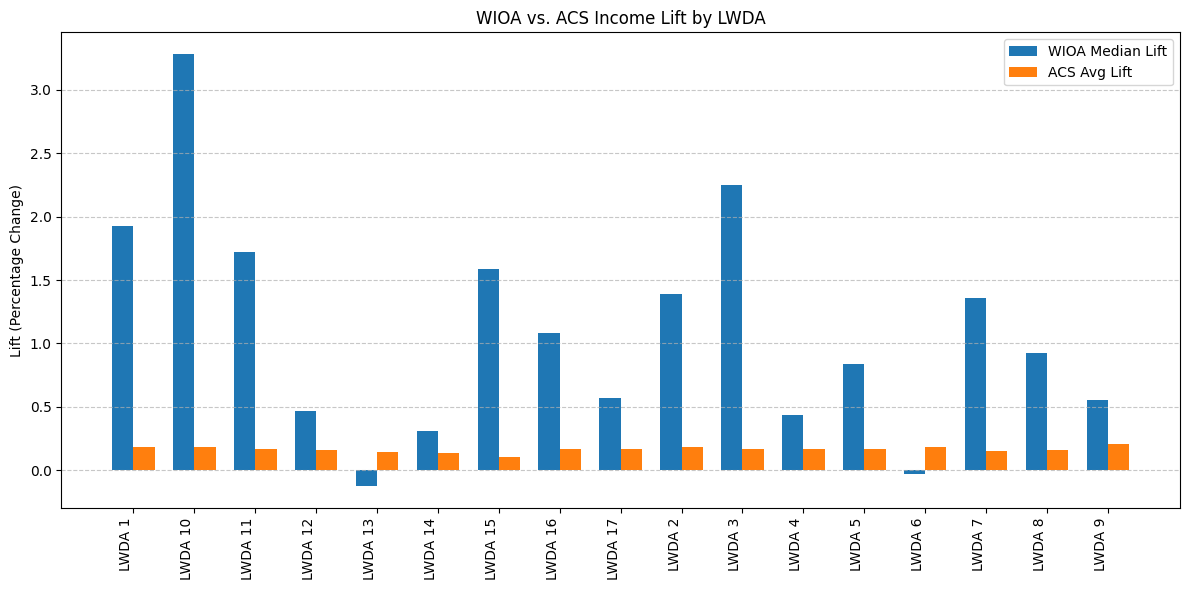

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Sort by LWDA to ensure consistent order
final_comparison_df = final_comparison_df.sort_values('lwda')

# Set figure size
plt.figure(figsize=(12, 6))

# X-axis positions
x = np.arange(len(final_comparison_df))

# Bar width
width = 0.35

# Plot bars
plt.bar(x - width/2, final_comparison_df['wioa_median_lift'], width, label='WIOA Median Lift')
plt.bar(x + width/2, final_comparison_df['acs_avg_lift'], width, label='ACS Avg Lift')

# X-ticks and labels
plt.xticks(x, final_comparison_df['lwda'], rotation=90, ha='right')
plt.ylabel("Lift (Percentage Change)")
plt.title("WIOA vs. ACS Income Lift by LWDA")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()